In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import ddpm

/ext3/miniconda3/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/ext3/miniconda3/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
import math
from collections.abc import Callable
from typing import Optional, Union
import functools as ft

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import optax
from jaxtyping import Key, Array, Float32, jaxtyped
import equinox as eqx
import einops as ein
import diffrax as dfx
import flax

TESTING = True
RETRAIN_MODEL = True
SEED = 42
key = jr.PRNGKey(SEED)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torchvision as tv

import cola
# from IPython.display import display, clear_output
from IPython import display
# torch.manual_seed(3)
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

2023-11-13 18:08:27.393459: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from configs import get_config
from sde_lib import VPSDE
import mutils
from sampling import EulerMaruyamaPredictor, LangevinCorrector, get_pc_sampler
import datasets
import utils

In [5]:
import os
import gdown

if not os.path.exists('checkpoint_26'):
    # Replace 'FILE_ID' with the actual file ID
    file_id = '1VZikdcPE2nn8K_da9UUG_JPIzNIRI4yE'

    # Specify the output file name
    output_file = 'checkpoint_26'

    # Download the file
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

if not os.path.exists('checkpoint_199'):
    # Replace 'FILE_ID' with the actual file ID
    file_id = '15VofLMDaxqUKnKwLDzvbDbCpCBm4nUOV'

    # Specify the output file name
    output_file = 'checkpoint_199'

    # Download the file
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

In [6]:
config = get_config()
sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

batch_size =   64
local_batch_size = batch_size // jax.local_device_count()
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0
rng = jax.random.PRNGKey(random_seed)
rng, run_rng = jax.random.split(rng)
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(run_rng, config)
# optimizer = losses_lib.get_optimizer(config).create(initial_params)
optimizer = None

state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                      model_state=init_model_state,
                      ema_rate=config.model.ema_rate,
                      params_ema=initial_params,
                      rng=rng)  # pytype: disable=wrong-keyword-args
sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
state = utils.load_training_state("checkpoint_26", state)

In [7]:
def reshape_tree(tree):
    reshaped_tree = {}
    for k, v in tree.items():
        if isinstance(v, dict) or isinstance(v, flax.core.FrozenDict):
            if 'GroupNorm' in k or 'bn' in k:
                reshaped_tree[k] =  v.copy({"scale": v["scale"].reshape(-1), "bias": v["bias"].reshape(-1)})
            else:
                reshaped_tree[k] = reshape_tree(v)
        else:
            reshaped_tree[k] = v
    return reshaped_tree

In [8]:
new_params = reshape_tree(state.params_ema)
# jtu.tree_map(lambda x: x.shape, new_params)
new_state = state.replace(params_ema=new_params)
random_seed = 0
rng = jax.random.PRNGKey(random_seed)
img_size = config.data.image_size
channels = config.data.num_channels
shape = (local_batch_size, img_size, img_size, channels)

In [9]:
rng = jax.random.PRNGKey(random_seed)

rng, step_rng = jax.random.split(rng)
x = sde.prior_sampling(step_rng, shape)
timesteps = jnp.linspace(sde.T, 1e-3, sde.N)
score_fn = mutils.get_score_fn(sde, score_model, new_params, state.model_state, train=False, continuous=config.training.continuous)
rsde = sde.reverse(score_fn, False)

i = 0

# @jax.jit
# def back_step(x, t, dt, rng):
#     rng, step_rng = jax.random.split(rng)
#     z = jr.normal(rng, shape)
#     drift, diffusion = rsde.sde(x, t)
#     x_mean = x + drift * dt
#     x = x_mean + utils.batch_mul(diffusion, jnp.sqrt(-dt) * z)
#     return x, x_mean, rng


# for i in range(sde.N):
#     t = timesteps[i]
#     vec_t = jnp.ones(shape[0]) * t
#     dt = -1.0 / sde.N
#     x, x_mean, rng = back_step(x, vec_t, dt, rng)
#     print(f"{i} / {sde.N}", end="\r")

In [10]:
# plt.imshow(ein.rearrange(inverse_scaler(x_mean), '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=8))

In [11]:

@jax.jit
def annealed_langevin(x, t, dt, rng):
    timestep = (t * (sde.N - 1) / sde.T).astype(jnp.int32)
    alpha = sde.alphas[timestep]

    std = sde.marginal_prob(x, t)[1]

    def loop_body(step, val):
        rng, x, x_mean = val
        grad = score_fn(x, t)
        rng, step_rng = jax.random.split(rng)
        noise = jax.random.normal(step_rng, x.shape)
        step_size = (target_snr * std) ** 2 * 2 * alpha
        x_mean = x + utils.batch_mul(step_size, grad)
        x = x_mean + utils.batch_mul(noise, jnp.sqrt(step_size * 2))
        return rng, x, x_mean

    rng, x, x_mean = jax.lax.fori_loop(0, 10, loop_body, (rng, x, x))
    return x, x_mean, rng

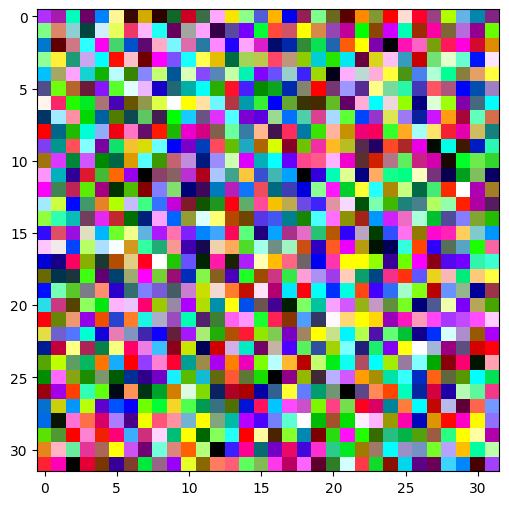

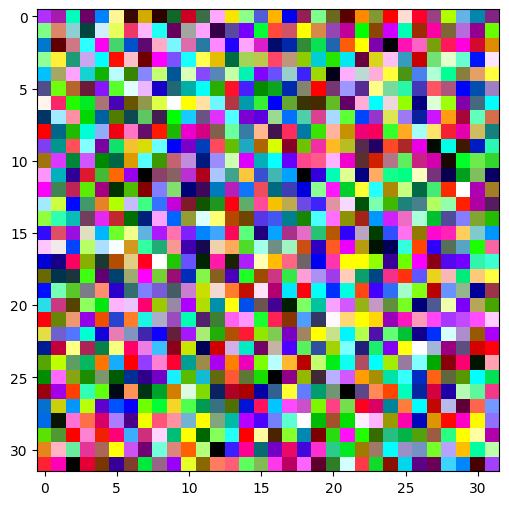

In [12]:
target_snr = 0.16
n_steps = 5000



@jax.jit
def make_step(x_pi, t, key):
    # Calculate step size
    alpha = sde.alphas[t]
    std = sde.marginal_prob(x_pi[None,...], jnp.ones(1)*t/(sde.N-1))[1]
    step_size = (target_snr * std) ** 2 * 2 * alpha
    
    # Calculate score
    score = score_fn(x_pi[None,...], jnp.ones(1)*t/(sde.N-1))

    # Noise for Langevin
    key, eps_key = jr.split(key)
    noise = jr.normal(eps_key, x_pi.shape)[None,...]

    # Langevin update
    x_mean = x_pi + utils.batch_mul(step_size, score)
    x_pi = x_mean + utils.batch_mul(noise, jnp.sqrt(step_size * 2))
    x_pi = x_pi[0]

    loss = None
    key = jr.split(key)[0]
    return x_pi, key


key = jr.PRNGKey(101)
x_pi = jr.normal(key, (32, 32, 3))
# Setup the plot outside of the loop
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
image1 = ax1.imshow(inverse_scaler(x_pi))

display.clear_output(wait=True)
image1.set_data(inverse_scaler(x_pi))
display.display(plt.gcf())


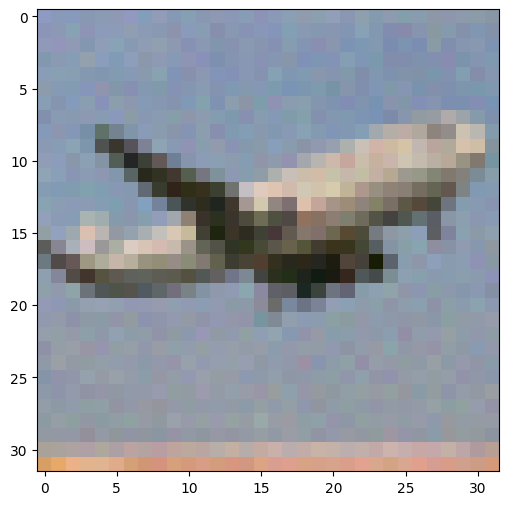

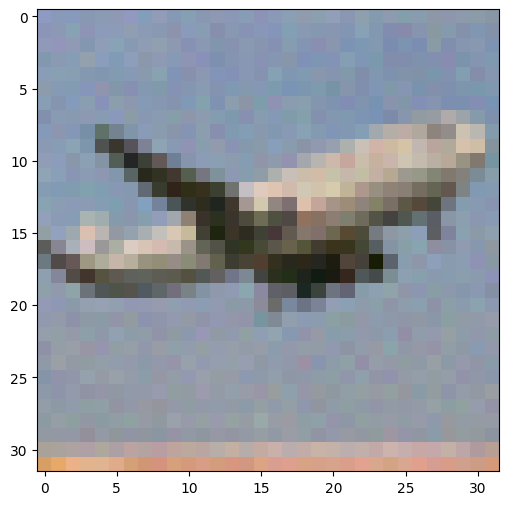

In [12]:
for step in range(n_steps):
    # Setup
    # key, t_key = jr.split(key)
    # t = jr.randint(t_key, (paas,), 30, sde.N-10)
    t = int((2*jax.nn.sigmoid(-6*step/n_steps))*sde.N)
    # t = jnp.ones((paas,), dtype=jnp.int32) * int(((n_steps-step)/n_steps)*sde.N)

    x_pi, key = make_step(x_pi, t, key)
    # print(f"Step {step}, t {t[0]/sde.N:.3f}, Loss {loss:.3f}", end="\r")
    print(f"Step {step}, t {t/sde.N:.3f}", end="\r")
    if step % 100 == 0 and step:
        # plt.imshow(inverse_scaler(jax.vmap(siren)(grid).reshape(img_size, img_size, 3)))
        display.clear_output(wait=True)
        image1.set_data(inverse_scaler(x_pi))
        display.display(plt.gcf())

In [13]:
from IPython.core.debugger import Pdb

In [14]:
class NystromPrecond(cola.ops.LinearOperator):
    """
    Constructs the Nystrom Preconditioner of a linear operator A.

    Args:
        A (LinearOperator): A positive definite linear operator of size (n, n).
        rank (int): The rank of the Nystrom approximation.
        mu (float): Regularization of the linear system (A + mu)x = b.
         Usually, this preconditioner is used to solve linear systems and
         therefore its construction accomodates for the regularization.
        eps (float): Shift used when constructing the preconditioner.
        adjust_mu (bool, optional): Whether to adjust the regularization with the
         estimatted dominant eigenvalue.

    Returns:
        LinearOperator: Nystrom Preconditioner.
    """
    def __init__(self, A, rank, mu=1e-7, eps=1e-8, adjust_mu=True, key=42):
        super().__init__(dtype=A.dtype, shape=A.shape)
        Omega = self.xnp.randn(*(A.shape[0], rank), dtype=A.dtype, device=A.device, key=key)
        self._create_approx(A=A, Omega=Omega, mu=mu, eps=eps, adjust_mu=adjust_mu)

    def _create_approx(self, A, Omega, mu, eps, adjust_mu):
        xnp = self.xnp
        self.Lambda, self.U = get_nys_approx(A=A, Omega=Omega, eps=eps)
        self.adjusted_mu = amu = mu * xnp.max(self.Lambda, axis=0) if adjust_mu else mu
        # Num and denom help for defining inverse and sqrt
        self.subspace_num = xnp.min(self.Lambda) + amu
        self.subspace_denom = self.Lambda + amu
        self.subspace_scaling = self.subspace_num / self.subspace_denom - 1
        self.subspace_scaling = self.subspace_scaling[:, None]
        self.preconditioned_eigmax = xnp.min(self.Lambda) + amu
        self.preconditioned_eigmin = amu

    def _matmat(self, V):
        subspace_term = self.U @ (self.subspace_scaling * (self.U.T @ V))
        return subspace_term + V


def get_nys_approx(A, Omega, eps):
    xnp = A.xnp
    Omega, _ = xnp.qr(Omega, full_matrices=False)
    Y = A @ Omega
    nu = eps * xnp.norm(Y, ord="fro")
    Y += nu * Omega
    C = xnp.cholesky(Omega.T @ Y)
    aux = xnp.solvetri(C, Y.T, lower=True)
    B = aux.T  # shape (params, rank)
    U, Sigma, _ = xnp.svd(B, full_matrices=False)
    Lambda = xnp.clip(Sigma**2.0 - nu, a_min=0.0)
    return Lambda, U

In [15]:
def flat_score_fn(x, t):
    x_img = x.reshape(1,32,32,3)
    score = score_fn(x_img, t*jnp.ones(1))
    return score.reshape(-1)

In [16]:
target_snr = 0.16
n_steps = 2000
from functools import partial
import cola
from cola import Auto, CG, Lanczos, PowerIteration


def score_hessian(x,t):
    H1 = cola.ops.Jacobian(partial(flat_score_fn,t=t), x)
    return cola.PSD(-(H1.T+H1)/2)

# @jax.jit
def get_matrices(x,t, key):
    H = score_hessian(x.reshape(-1),t)
    P = cola.ops.I_like(H)#NystromPrecond(H, rank=30, mu=1e-1, key=key)
    eps = 1e-2*cola.eigmax(H, alg=PowerIteration(max_iter=5))#P.adjusted_mu
    Pdb().set_trace()

    
    reg_H = cola.PSD(H + eps*cola.ops.I_like(H))
    #U = cola.lazify(P.U)
    #D2 = cola.ops.Diagonal(jnp.sqrt(1+P.subspace_scaling[:,0])-1)
    sqrtP = P#U @ D2 @ U.T + cola.ops.I_like(P)
    #D3 = cola.ops.Diagonal((1+P.subspace_scaling[:,0])**0.25-1)
    P_quart = cola.ops.I_like(P)#U @ D3 @ U.T + cola.ops.I_like(P)
    inv_H = cola.linalg.inv(reg_H, alg=CG(max_iters=10, P=P))
    #A = cola.PSD(sqrtP @ reg_H @ sqrtP)
    #isqrt_H = P_quart @ cola.linalg.isqrt(A, alg=Lanczos(max_iters=10)) @ P_quart
    isqrt_H = cola.linalg.isqrt(reg_H, alg=Lanczos(max_iters=10))
    return inv_H, isqrt_H

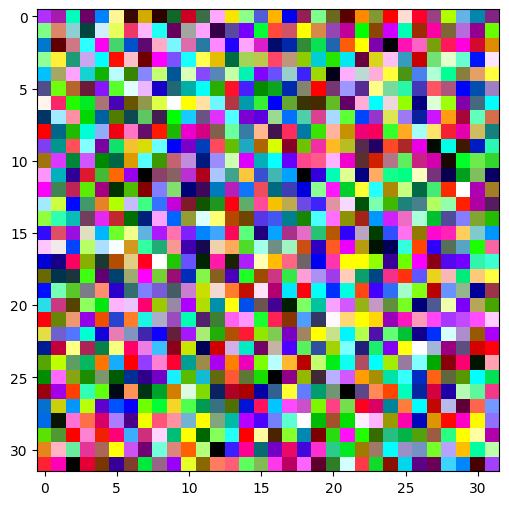

> /state/partition1/job-40110068/ipykernel_2406360/3965836461.py(43)<module>()
     41     # key, t_key = jr.split(key)
     42     # t = jr.randint(t_key, (paas,), 30, sde.N-10)
---> 43     t = int((2*jax.nn.sigmoid(-6*step/n_steps))*sde.N)
     44     # t = jnp.ones((paas,), dtype=jnp.int32) * int(((n_steps-step)/n_steps)*sde.N)
     45 



ipdb>  l


     38 for step in range(n_steps):
     39     Pdb().set_trace()
     40     # Setup
     41     # key, t_key = jr.split(key)
     42     # t = jr.randint(t_key, (paas,), 30, sde.N-10)
---> 43     t = int((2*jax.nn.sigmoid(-6*step/n_steps))*sde.N)
     44     # t = jnp.ones((paas,), dtype=jnp.int32) * int(((n_steps-step)/n_steps)*sde.N)
     45 
     46     x_pi, key = make_step(x_pi, t, key)
     47     # print(f"Step {step}, t {t[0]/sde.N:.3f}, Loss {loss:.3f}", end="\r")
     48     print(f"Step {step}, t {t/sde.N:.3f}", end="\r")



ipdb>  c


> /state/partition1/job-40110068/ipykernel_2406360/3965836461.py(15)make_step()
     13 
     14     # Noise for Langevin
---> 15     key, eps_key = jr.split(key)
     16     noise = jr.normal(eps_key, x_pi.shape)[None,...]
     17 



ipdb>  l


     10     score = score_fn(x_pi[None,...], jnp.ones(1)*t/(sde.N-1))
     11     Pdb().set_trace()
     12 
     13 
     14     # Noise for Langevin
---> 15     key, eps_key = jr.split(key)
     16     noise = jr.normal(eps_key, x_pi.shape)[None,...]
     17 
     18     key, pkey = jr.split(key)
     19     inv_H, isqrt_H = get_matrices(x_pi, t/(sde.N-1), pkey)
     20     # Langevin update



ipdb>  score


Array([[[[-0.39628005,  0.62515235, -1.6585238 ],
         [-0.30147612,  0.7819251 , -0.3428945 ],
         [ 1.3472438 , -1.7811029 , -0.48028794],
         ...,
         [ 0.20773342, -0.3970177 , -0.7895676 ],
         [ 3.075234  , -0.06048543, -0.34707987],
         [-0.04049047,  0.7202895 , -0.05293918]],

        [[ 0.01642539, -1.4287863 , -0.06372819],
         [-0.71092176, -0.0649247 ,  0.17673746],
         [-0.10474903, -0.63340735, -0.6672268 ],
         ...,
         [-0.43132472,  0.16265841, -0.7191334 ],
         [-0.15271041,  1.3904352 , -0.13139471],
         [ 0.1729356 , -2.0690467 ,  1.2096071 ]],

        [[ 1.5436499 ,  0.05702796, -0.61622685],
         [ 0.2652926 ,  1.3743364 ,  2.4509075 ],
         [-0.6241195 ,  0.05486676, -0.03791048],
         ...,
         [-1.293275  ,  1.0757096 , -0.72992057],
         [-0.65614635,  0.92448264,  0.64374346],
         [-0.753086  , -0.10354564,  1.6402733 ]],

        ...,

        [[ 0.28327686, -0.77902687,  1

ipdb>  score.shape


(1, 32, 32, 3)


ipdb>  score.device


<bound method ArrayImpl.device of Array([[[[-0.39628005,  0.62515235, -1.6585238 ],
         [-0.30147612,  0.7819251 , -0.3428945 ],
         [ 1.3472438 , -1.7811029 , -0.48028794],
         ...,
         [ 0.20773342, -0.3970177 , -0.7895676 ],
         [ 3.075234  , -0.06048543, -0.34707987],
         [-0.04049047,  0.7202895 , -0.05293918]],

        [[ 0.01642539, -1.4287863 , -0.06372819],
         [-0.71092176, -0.0649247 ,  0.17673746],
         [-0.10474903, -0.63340735, -0.6672268 ],
         ...,
         [-0.43132472,  0.16265841, -0.7191334 ],
         [-0.15271041,  1.3904352 , -0.13139471],
         [ 0.1729356 , -2.0690467 ,  1.2096071 ]],

        [[ 1.5436499 ,  0.05702796, -0.61622685],
         [ 0.2652926 ,  1.3743364 ,  2.4509075 ],
         [-0.6241195 ,  0.05486676, -0.03791048],
         ...,
         [-1.293275  ,  1.0757096 , -0.72992057],
         [-0.65614635,  0.92448264,  0.64374346],
         [-0.753086  , -0.10354564,  1.6402733 ]],

        ...,

    

ipdb>  score.device()


CpuDevice(id=0)


ipdb>  l


     21     x_mean = x_pi + utils.batch_mul(step_size, (inv_H@score.reshape(-1)).reshape(score.shape))
     22     x_pi = x_mean + utils.batch_mul((isqrt_H@noise.reshape(-1)).reshape(noise.shape), jnp.sqrt(step_size * 2))
     23     x_pi = x_pi[0]
     24     return x_pi, key
     25 
     26 # Setup the plot outside of the loop
     27 fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
     28 image1 = ax1.imshow(inverse_scaler(x_pi))
     29 
     30 key = jr.PRNGKey(101)
     31 x_pi = jr.normal(key, (32, 32, 3))



ipdb>  c


> /state/partition1/job-40110068/ipykernel_2406360/499947603.py(20)get_matrices()
     18 
     19 
---> 20     reg_H = cola.PSD(H + eps*cola.ops.I_like(H))
     21     #U = cola.lazify(P.U)
     22     #D2 = cola.ops.Diagonal(jnp.sqrt(1+P.subspace_scaling[:,0])-1)



ipdb>  l


     15     P = cola.ops.I_like(H)#NystromPrecond(H, rank=30, mu=1e-1, key=key)
     16     eps = 1e-2*cola.eigmax(H, alg=PowerIteration(max_iter=5))#P.adjusted_mu
     17     Pdb().set_trace()
     18 
     19 
---> 20     reg_H = cola.PSD(H + eps*cola.ops.I_like(H))
     21     #U = cola.lazify(P.U)
     22     #D2 = cola.ops.Diagonal(jnp.sqrt(1+P.subspace_scaling[:,0])-1)
     23     sqrtP = P#U @ D2 @ U.T + cola.ops.I_like(P)
     24     #D3 = cola.ops.Diagonal((1+P.subspace_scaling[:,0])**0.25-1)
     25     P_quart = cola.ops.I_like(P)#U @ D3 @ U.T + cola.ops.I_like(P)



ipdb>  H


<3072x3072 Product[cola.ops.operators.ScalarMul, cola.ops.operators.Product[cola.ops.operators.ScalarMul, cola.ops.operators.Sum[cola.ops.operators.Transpose[cola.ops.operators.Jacobian], cola.ops.operators.Jacobian]]] with dtype=float32>


ipdb>  dir(H)


['H', 'Ms', 'T', '__add__', '__annotations__', '__array_ufunc__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__matmul__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmatmul__', '__rmul__', '__rtruediv__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_concrete', '_dynamic', '_matmat', '_parametric', '_rmatmat', '_type_parameter', 'annotations', 'device', 'dtype', 'flatten', 'isa', 'shape', 'to', 'to_dense', 'tree_flatten', 'tree_unflatten', 'xnp']


ipdb>  H.shape


(3072, 3072)


ipdb>  H


<3072x3072 Product[cola.ops.operators.ScalarMul, cola.ops.operators.Product[cola.ops.operators.ScalarMul, cola.ops.operators.Sum[cola.ops.operators.Transpose[cola.ops.operators.Jacobian], cola.ops.operators.Jacobian]]] with dtype=float32>


ipdb>  eig_vals, eig_vecs = np.linalg.eigh(H)


*** numpy.linalg.LinAlgError: 0-dimensional array given. Array must be at least two-dimensional


ipdb>  eig_vals, eig_vecs = cola.eig(H, k=30, which='LM', alg=cola.Lanczos(max_iters=30, tol=1e-3, pbar=True))


Running body_fun: 100%|██████████| 100/100 [04:39<00:00, 2.80s/it] 


ipdb>  eig_vals


Array([0.9472447 , 0.9700805 , 0.9778428 , 0.9804493 , 0.9820809 ,
       0.9838983 , 0.984675  , 0.98506224, 0.9864354 , 0.9878241 ,
       0.9905946 , 0.9915226 , 0.993013  , 0.9939531 , 0.99534494,
       0.9967226 , 0.99800235, 0.9989913 , 0.9999341 , 1.0008798 ,
       1.0019948 , 1.0031228 , 1.0041935 , 1.0050408 , 1.0058535 ,
       1.0067973 , 1.00727   , 1.0083396 , 1.0094253 , 1.013133  ],      dtype=float32)


ipdb>  eig_vals, eig_vecs = cola.eig(H, k=30, which='SM', alg=cola.Lanczos(max_iters=30, tol=1e-3, pbar=True))


Running body_fun: 100%|██████████| 100/100 [04:39<00:00, 2.80s/it] 


ipdb>  eig_vals


Array([0.9472447 , 0.9700805 , 0.9778428 , 0.9804493 , 0.9820809 ,
       0.9838983 , 0.984675  , 0.98506224, 0.9864354 , 0.9878241 ,
       0.9905946 , 0.9915226 , 0.993013  , 0.9939531 , 0.99534494,
       0.9967226 , 0.99800235, 0.9989913 , 0.9999341 , 1.0008798 ,
       1.0019948 , 1.0031228 , 1.0041935 , 1.0050408 , 1.0058535 ,
       1.0067973 , 1.00727   , 1.0083396 , 1.0094253 , 1.013133  ],      dtype=float32)


ipdb>  q


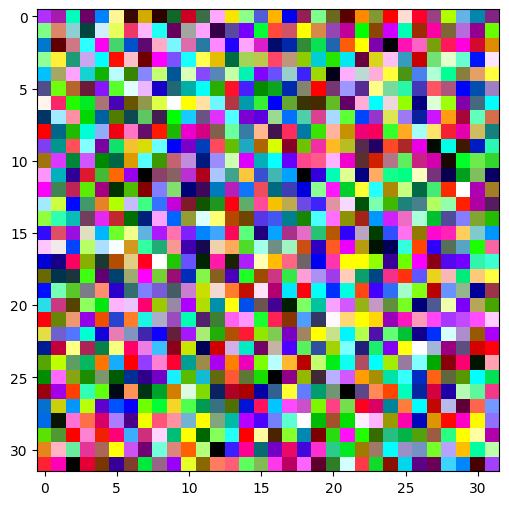

In [17]:


# TODO: yilun's changes in commenting this out
# @jax.jit
def make_step(x_pi, t, key):
    # Calculate step size
    alpha = sde.alphas[t]
    std = sde.marginal_prob(x_pi[None,...], jnp.ones(1)*t/(sde.N-1))[1]
    step_size = (target_snr * std) ** 2 * 2 * alpha

    # Calculate score
    score = score_fn(x_pi[None,...], jnp.ones(1)*t/(sde.N-1))
    Pdb().set_trace()
    
    
    # Noise for Langevin
    key, eps_key = jr.split(key)
    noise = jr.normal(eps_key, x_pi.shape)[None,...]

    key, pkey = jr.split(key)
    inv_H, isqrt_H = get_matrices(x_pi, t/(sde.N-1), pkey)
    # Langevin update
    x_mean = x_pi + utils.batch_mul(step_size, (inv_H@score.reshape(-1)).reshape(score.shape))
    x_pi = x_mean + utils.batch_mul((isqrt_H@noise.reshape(-1)).reshape(noise.shape), jnp.sqrt(step_size * 2))
    x_pi = x_pi[0]
    return x_pi, key

# Setup the plot outside of the loop
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
image1 = ax1.imshow(inverse_scaler(x_pi))

key = jr.PRNGKey(101)
x_pi = jr.normal(key, (32, 32, 3))

display.clear_output(wait=True)
image1.set_data(inverse_scaler(x_pi))
display.display(plt.gcf())


for step in range(n_steps):
    Pdb().set_trace()
    # Setup
    # key, t_key = jr.split(key)
    # t = jr.randint(t_key, (paas,), 30, sde.N-10)
    t = int((2*jax.nn.sigmoid(-6*step/n_steps))*sde.N)
    # t = jnp.ones((paas,), dtype=jnp.int32) * int(((n_steps-step)/n_steps)*sde.N)

    x_pi, key = make_step(x_pi, t, key)
    # print(f"Step {step}, t {t[0]/sde.N:.3f}, Loss {loss:.3f}", end="\r")
    print(f"Step {step}, t {t/sde.N:.3f}", end="\r")
    
    Pdb().set_trace()

    
    if step % 10 == 0 and step:
        # plt.imshow(inverse_scaler(jax.vmap(siren)(grid).reshape(img_size, img_size, 3)))
        display.clear_output(wait=True)
        image1.set_data(inverse_scaler(x_pi))
        display.display(plt.gcf())

In [17]:
key = jr.PRNGKey(101)
x = jr.normal(key, (32, 32, 3))

invH, isqrtH, P, H = get_matrices(x, 1-10/sde.N, key)

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
Hdense = P.to_dense()
es = jnp.linalg.eigvalsh(Hdense)
plt.plot(es)

In [33]:
P.Lambda

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan], dtype=float32)

In [27]:
key = jr.PRNGKey(101)
x = jr.normal(key, (32, 32, 3))

invH, isqrtH = get_matrices(x, 1-10/sde.N, key)

In [ ]:
invH

In [25]:
x = jr.normal(key, (32, 32, 3))
e,v = cola.eig(score_hessian(x.reshape(-1), 1-10/sde.N),k=10, which='SM', alg=Lanczos(max_iters=30))

In [26]:
e

Array([0.96018845, 0.97582316, 0.9786645 , 0.98018295, 0.9819377 ,
       0.9826432 , 0.98349875, 0.9841264 , 0.98638034, 0.98889446],      dtype=float32)

In [ ]:
import time
import pickle
import cola
from cola.linalg.decompositions.lanczos import lanczos_eigs


def log_spectrum_results(A, alg, results, output_path):
    out = get_spectrum_results(A, alg=alg)
    results.append(out)
    save_object(results, output_path)


def get_spectrum_results(A, alg):
    tic = time.time()
    if isinstance(alg, cola.Lanczos):
        # TODO: AP to fix this
        eigvals, *_ = lanczos_eigs(A, **alg.__dict__)
        method_name = "lanczos"
    else:
        eigvals, _ = cola.eig(A, k=A.shape[0], alg=alg)
        method_name = "cholesky"
    toc = time.time()
    return {"eigvals": eigvals, "time": toc - tic, "method": method_name}


def save_object(obj, filepath, use_highest=True):
    protocol = pickle.HIGHEST_PROTOCOL if use_highest else pickle.DEFAULT_PROTOCOL
    with open(file=filepath, mode='wb') as f:
        pickle.dump(obj=obj, file=f, protocol=protocol)


In [ ]:
from jax.random import normal
from jax.random import PRNGKey
import cola
from experiments.experiment_fns import log_spectrum_results

key = PRNGKey(seed=42)
# N = 1000
N = 10
h = normal(key, shape=(N, ))
H = cola.ops.Diagonal(h)
# h = normal(key, shape=(N, N))
# H = cola.ops.Dense(h @ h.T)
H = cola.SelfAdjoint(H)

results = []
output_path = "./logs/eigs.pkl"
log_spectrum_results(H, alg=cola.Eigh(), results=results, output_path=output_path)

max_iters = 10
alg = cola.Lanczos(max_iters=max_iters, tol=1e-3)
log_spectrum_results(H, alg=alg, results=results, output_path=output_path)
